In [2]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall
import gc
from tqdm import tqdm_notebook
from functools import reduce

In [3]:
# available for test:
# 20921, 20916, 20761, 20755, 20754, 20743, 20717, 20323
# 1921, 1911, 1899, 1831, 1826, 1813, 1808, 704, 702, 635, 628, 626, 615, 593,
# 456, 454, 435, 432, 411, 401, 309, 308, 305, 302, 239, 228, 231, 200, 158, 150, 
# 126, 119, 118, 117, 116, 115, 114, 113

# available for experiments:
# 114, 115, 116, 117, 119, 302, 303, 304, 305, 306, 307,
# 308, 309, 393, 442, 470, 471, 472, 502, 503, 504, 505,
# 506, 507, 508, 511, 512, 513, 514, 515, 516, 591, 592,
# 593, 596, 597, 599, 612, 613, 614, 615, 616, 617, 618,
# 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629,
# 836, 837, 838, 839, 862, 863, 874, 875, 888, 1820, 1832,
# 1833, 1834, 1835, 1836, 1838, 1896, 1899, 4007

# small outliers:
# 114, 119, 302, 303, 442, 511, 512, 514, 629, 838, 839

# big bugs
# 307, 393, 503, 504, 505, 516, 619, 1838, 1896 -- big bugs

## Loading data

In [4]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)
train_clean = get_clean_data(train)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)
test['label_true'] = get_labels(test, labels_type='true')

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 31s, sys: 10.3 s, total: 1min 41s
Wall time: 1min 45s


In [5]:
train

,date_time_utc,data_t_underroad,data_pressure,data_t_road,data_t_air,date_time,data_dampness,id_t_road,station_id,data_solar_azimuth,data_solar_altitude,data_latitude,data_longitude,data_road
0,2012-09-18 09:00:00,18.028571,739.214286,18.628571,15.314286,2012-09-18 12:00:00,68.785714,117040733.0,113,1.168394,0.285418,54.447,53.603,54
1,2012-09-18 09:30:00,18.140476,739.311905,18.757143,15.361905,2012-09-18 12:30:00,68.388095,117040733.0,113,1.281520,0.213842,54.447,53.603,54
2,2012-09-18 10:00:00,18.252381,739.409524,18.885714,15.409524,2012-09-18 13:00:00,67.990476,117040733.0,113,1.391228,0.139844,54.447,53.603,54
3,2012-09-18 10:30:00,18.364286,739.507143,19.014286,15.457143,2012-09-18 13:30:00,67.592857,117040733.0,113,1.498755,0.064368,54.447,53.603,54
4,2012-09-18 11:00:00,18.476190,739.604762,19.142857,15.504762,2012-09-18 14:00:00,67.195238,117040733.0,113,1.605342,-0.011695,54.447,53.603,54
5,2012-09-18 11:30:00,18.588095,739.702381,19.271429,15.552381,2012-09-18 14:30:00,66.797619,117040733.0,113,1.712222,-0.087477,54.447,53.603,54
6,2012-09-18 12:00:00,18.700000,739.800000,19.550000,15.625000,2012-09-18 15:00:00,65.950000,117040733.0,113,1.820626,-0.162104,54.447,53.603,54
7,2012-09-18 12:30:00,18.700000,739.800000,19.700000,15.650000,2012-09-18 15:30:00,65.500000,117051692.0,113,1.931776,-0.234663,54.447,53.603,54
8,2012-09-18 13:00:00,18.700000,739.800000,19.850000,15.675000,2012-09-18 16:00:00,65.050000,117051692.0,113,2.046866,-0.304180,54.447,53.603,54
9,2012-09-18 13:30:00,18.500000,739.800000,19.800000,15.533333,2012-09-18 16:30:00,65.533333,117051692.0,113,2.167032,-0.369591,54.447,53.603,54


## Feature selection

In [57]:
%%time

from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

time = 0
lag_list=(1, 2, 3)
diff_list=((1, 2), (1, 3))
post_process = False
variables=('data_t_road', )

df_train = create_feature_df(train[train['date_time_utc'] < point], 
                             winter_period=False, time=time, lag_list=lag_list,
                             diff_list=diff_list, post_process=post_process, variables=variables)
df_valid = create_feature_df(train[train['date_time_utc'] >= point], 
                             winter_period=False, time=time, lag_list=lag_list,
                             diff_list=diff_list, post_process=post_process, variables=variables)
df_test = create_feature_df(test, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables)

features = [col for col in df_train if col.startswith('data_')]
target = [col for col in df_train if col.startswith('target_')]

X_train = np.array(df_train[features + target])
#y_train = np.array(df_train[target])

X_valid = np.array(df_valid[features + target])
#y_valid = np.array(df_valid[target])

X_test = np.array(df_test[features + target])
#y_test = np.array(df_test[target].values.reshape(-1, 1))

CPU times: user 3.66 s, sys: 832 ms, total: 4.49 s
Wall time: 4.49 s


In [61]:
import pickle

df_test.to_csv('/mnt/HARD/MinMax94/models/results/isolation_forest.csv', index=False)
pickle.dump(clf, open('/mnt/HARD/MinMax94/models/pickle/isolation_forest.pickle', "wb"))

In [58]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.005)
clf.fit(X_train)

df_test['label_predict'] = (1 - clf.predict(X_test)) / 2
df_test['decision_function'] = clf.decision_function(X_test)

## Recall

In [59]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')

st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    predicted_anomalies = df[df['label_predict']==1]
    for anomaly in predicted_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        predicted_anomalies_ids.update(set(locality.index))

true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
recall = len(tp) / len(true_anomalies_ids)
recall

0.3950617283950617

## Precision

In [60]:
true_anomalies_ids = set()
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    true_anomalies = df[df['label_true']==1]
    for anomaly in true_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        true_anomalies_ids.update(set(locality.index))
        # print(list(locality.index))

predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
precision = len(tp) / len(predicted_anomalies_ids)
precision

0.2523961661341853

## Plot

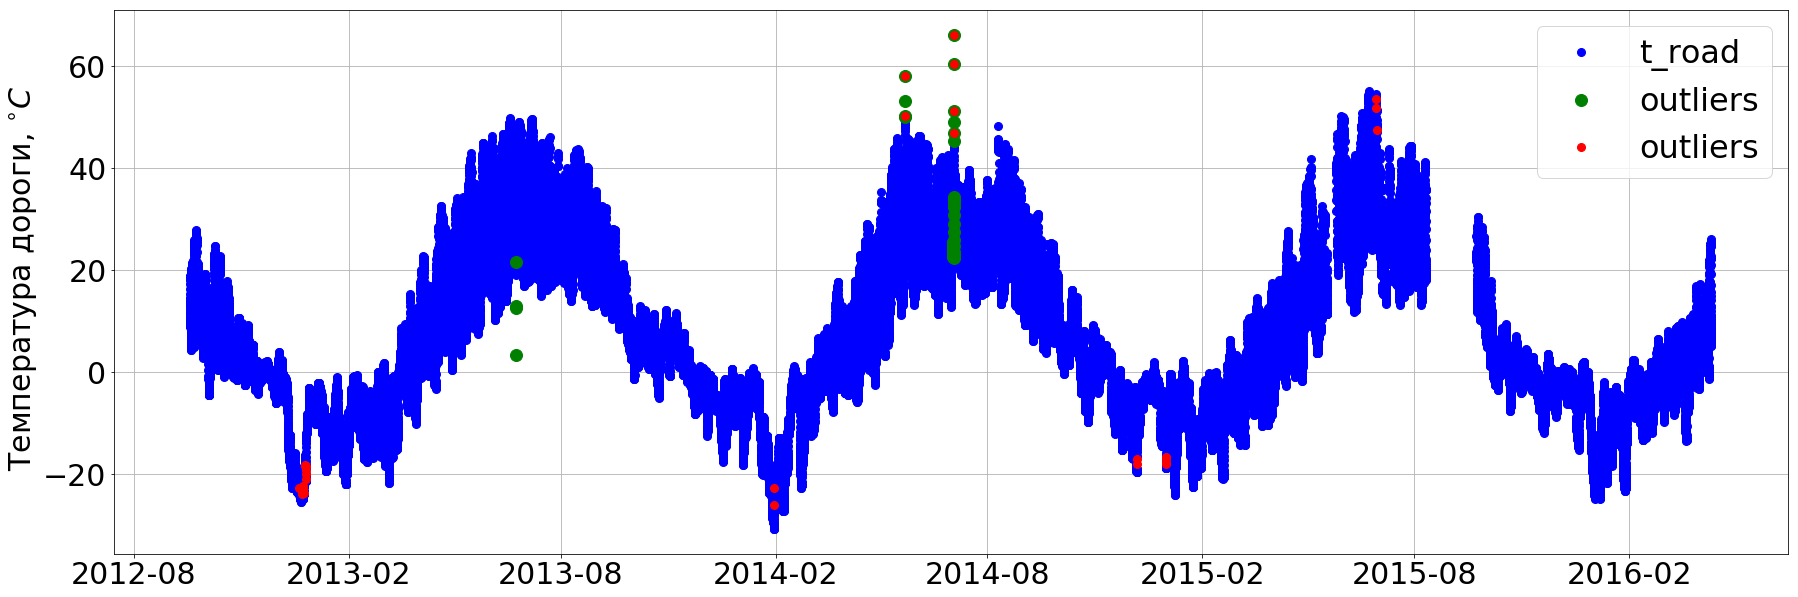

In [62]:
import matplotlib.pyplot as plt

#st_id = [114, 117, 119, 442, 504, 511, 1838, 1896]
#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==114].set_index('date_time_utc'))

start = pd.Timestamp(2012, 7, 1)
end = pd.Timestamp(2017, 8, 15)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()